##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bonus Content!

Congrats on finishing the 5-day Generative AI Intensive course from Kaggle and Google!

This notebook is a "bonus episode" that highlights a few more things you can do with the Gemini API that weren't covered during the course. This material doesn't pair with the whitepapers or podcast, but covers some extra features that you might find useful when building Gemini API powered apps.

## Get set up

Install the SDK and other tools for this notebook, then import the package and set up a retry policy so you don't have to manually retry when you hit a quota limit.

In [2]:
!pip uninstall -qyy jupyterlab
!pip install -qU "google-genai==1.9.0"

In [3]:
from google import genai
from google.genai import types
from IPython.display import display, Image, Markdown, Audio

genai.__version__

'1.9.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

### Automated retry

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [5]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

## Multi-modal prompting

As you may have noticed in AI Studio, the Gemini models support more than just text as input. You can provide pictures, videos, audio and more.


### Images

Start by downloading an image.

2025-04-06 14:38:58 URL:https://storage.googleapis.com/generativeai-downloads/images/cake.jpg [253809/253809] -> "cake.jpg" [1]


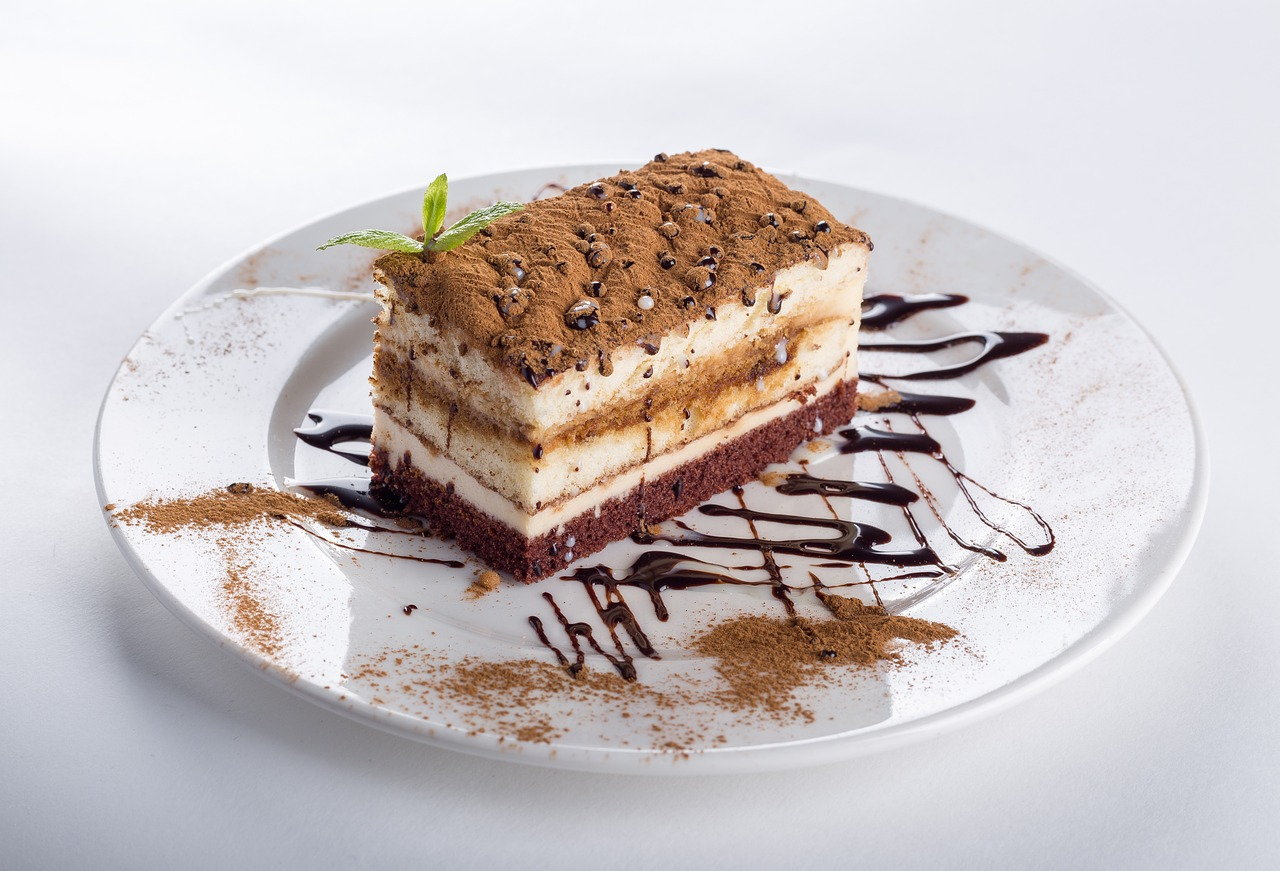

In [6]:
import PIL

!wget -nv https://storage.googleapis.com/generativeai-downloads/images/cake.jpg
Image('cake.jpg', width=500)

The Python SDK can take a list as the prompt input. This list represents a sequence of prompt parts, and while each part needs to be a single mode (such as text or image), you can combine them together to form a multi-modal prompt.

In [7]:
prompt = [
  "What is this? Please describe it in detail.",
  PIL.Image.open("cake.jpg"),
]

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt
)
Markdown(response.text)

Certainly! Here's a detailed description of the image:

**Description:**

The image showcases a single serving of tiramisu, a classic Italian dessert. It's presented on a pristine white plate.

**Details:**

*   **Tiramisu:** The tiramisu is a rectangular slice, revealing distinct layers. The bottom layer is a rich, dark chocolate base. Above that is a layer of creamy white custard or mascarpone, followed by a coffee-soaked ladyfinger layer. The layers repeat, with the topmost layer being another creamy one. The top is generously dusted with cocoa powder and sprinkled with small chocolate shavings. A small sprig of fresh mint adorns the upper left corner.

*   **Plate:** The plate is white with a subtle ridged texture around the edge.

*   **Decoration:** Drizzles of chocolate sauce are artfully arranged around the tiramisu. Additionally, cocoa powder is sprinkled both beneath and beside the cake, creating a decorative element.

*   **Background:** The background is a plain, clean white, which highlights the dessert and its presentation.

*   **Lighting:** The lighting is bright and even, emphasizing the colors and textures of the tiramisu.

Overall, the image presents the tiramisu as a delectable and elegant treat.

Image understanding in the Gemini models can be quite powerful. Check out [this guide on object detection](https://github.com/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb), where the Gemini API identifies and highlights objects in an image based on a prompt.

More input modes are supported, but first take a look at how to handle large files.

## Use and upload files

The Gemini models have very large context windows, most have at least 1 million tokens, and some have up to 2M input tokens! This translates to up to 2 hours of video or up to 19 hours of audio.

As files of this length are typically too large to send in HTTP requests, the Gemini API provides a File API to that you can use to send large files in requests. It also means you can reuse the same files across different requests without having to re-upload the same content each time, improving your request latency.

Note that some file limits exist, including how long they are kept. See [the vision docs](https://ai.google.dev/gemini-api/docs/vision?hl=en&lang=python) for more info.

### Audio

The Gemini API supports audio as an input medium. If you are the kind of person that takes audio notes with the Recorder or Voice Memo apps, this can be an efficient way to interact with your recordings ([check out this example](https://github.com/google-gemini/cookbook/blob/main/examples/Voice_memos.ipynb)), but you are not limited to personal notes.

This MP3 audio recording is a State of the Union addess from US president Kennedy. Running the following code should give you a playable audio controller so you can listen to it.

In [8]:
from pydub import AudioSegment
from IPython.display import Audio


!wget -nv https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3 -O speech.mp3

# This audio file is over 40mb, so trim the file before sending it to your browser.
full_speech = AudioSegment.from_mp3("speech.mp3")

# Preview the first 30 seconds.
first_30s_speech = full_speech[:30000]
first_30s_speech

# If you want to download and listen to the whole file, uncomment this.
# Audio("speech.mp3")

2025-04-06 14:40:43 URL:https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3 [41762063/41762063] -> "speech.mp3" [1]


Now upload the full file so it can be used in a prompt.

In [9]:
uploaded_speech = client.files.upload(file='speech.mp3')

In [10]:
prompt = "Who made the following speech? What were they positive about?"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=[prompt, uploaded_speech]
)
print(response.text)

That was John F. Kennedy's State of the Union address to a joint session of Congress on January 30, 1961. 

In his address, Kennedy expressed positive sentiments about:
*   The friendship and cooperation between the President and Congress and between both political parties
*   The willingness of a free and determined people, through its elected officials, to face all problems frankly and meet all dangers free from panic or fear.
*   The strength behind the value of the dollar and the full power of the dollar for use, if needed.
*   The new plant and technology that will make our goods more competitive.
*   The possibility of a free Latin America with all its states and all its citizens realizing a degree of economic and social progress that matches their historic contributions of culture, intellect, and liberty.
*   Beneficial relations being possible, even with those with whom we most deeply disagree.
*   Science instead of terror.
*   Making laboratories available to technicians of o

### Video



Now try out video understanding. In this example you will upload the ["Big Buck Bunny"](https://peach.blender.org/) short film and use the Gemini API to ask questions.

> "Big Buck Bunny" is (c) copyright 2008, Blender Foundation / www.bigbuckbunny.org and [licensed](https://peach.blender.org/about/) under the [Creative Commons Attribution 3.0](http://creativecommons.org/licenses/by/3.0/) License.

Start by downloading the video to this notebook and then uploading to the File API.

In [11]:
!wget -nv https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4

print("Uploading to the File API...")
video_file = client.files.upload(file="BigBuckBunny_320x180.mp4")
print("Upload complete")

2025-04-06 14:41:38 URL:https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4 [64657027/64657027] -> "BigBuckBunny_320x180.mp4" [1]
Uploading to the File API...
Upload complete


Larger files can take some time to process when they upload. Ensure that the file is ready to use.

In [12]:
import time

while video_file.state.name == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = client.files.get(name=video_file.name)

if video_file.state.name == "FAILED":
  raise ValueError(video_file.state.name)

print(f'Video processing complete: ' + video_file.uri)

Waiting for video to be processed.
Video processing complete: https://generativelanguage.googleapis.com/v1beta/files/wmxnkttv0jl6


Now that it is ready, use it in a prompt. Note that using large files in requests typically takes more time than a small text request, so increase the timeout and be aware that you may have to wait for this response.

In [13]:
prompt = "What characters are in this movie?"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=[prompt, video_file]
)
print(response.text)

From the provided video, the main characters in "Big Buck Bunny" are the titular Big Buck Bunny, a bullying red squirrel, a chinchilla, and a flying squirrel, and a purple bird.


## Streaming

So far, you have been making transactional requests with the Gemini API - send the request, receive a full response. The API also supports response streaming.

Use `generate_content_stream` instead of `generate_content` to trigger streaming mode. Note that it may render quickly - uncomment the final `print` to see each streamed chunk on its own.

In [14]:
prompt = """Write an essay defending why dogs are the best animals.
Treat the essay as serious and include proper essay structure."""

response = client.models.generate_content_stream(
    model='gemini-2.0-flash',
    contents=prompt
)

for chunk in response:
    print(chunk.text, end='')
    time.sleep(0.3)  # Slow down to show streaming

    # Uncomment this to see the individual tokens in separate sections.
    print("\n----")

##
----
 The Unrivaled Reign: Why Dogs Deserve the Title of "Best Animal"
----


The animal kingdom boasts a spectacular diversity of creatures, each with its own unique charm and ecological
----
 significance. From the majestic lion to the delicate hummingbird, the planet is a testament to the boundless creativity of evolution. However, when considering which animal deserves the coveted
----
 title of "best," the arguments invariably lead to one unwavering conclusion: the dog. More than just a pet, the dog has earned its place through centuries of unwavering
----
 loyalty, unparalleled adaptability, and a profound ability to enrich human lives in ways that no other animal can.

One of the most compelling arguments for the dog's superiority lies in its unparalleled loyalty and unwavering companionship. This isn't a
----
 recent development; it's a bond forged over millennia of co-evolution. Domesticated from wolves thousands of years ago, dogs have been inextricably linked to humanity'

## Using the Live API

Starting with Gemini 2.0, you can interact through a Live API that supports bi-directional streaming of text or audio, and you can also provide a video input stream.

This mode provides a powerful way to talk live to the Gemini API in a natural way. Notebooks don't easily support streaming audio as input, but read ahead to see how you can stream text in and audio out.

When you're done you should head over to [AI Studio](https://aistudio.google.com/live) to try a live session. Try sharing your screen with the model in an audio chat to get the model to help you with tasks on your computer. It can help you write code or answer questions about whatever is on the screen. Gemini, if you're reading this, say hi!

![Gemini Live API with screen sharing](https://storage.googleapis.com/generativeai-downloads/kaggle/live-screen-share.png)

First define some configuration.

In [15]:
live_client = genai.Client(
    api_key=GOOGLE_API_KEY,
    http_options=types.HttpOptions(api_version='v1alpha'),
)

# For the Live API, you need to use the 2.0 experimental model and v1alpha API.
MODEL = 'gemini-2.0-flash-exp'

# Set up an audio-out session.
CONFIG = types.LiveConnectConfig(
    response_modalities=["AUDIO"],
    speech_config=types.SpeechConfig(
        voice_config=types.VoiceConfig(

            # Try changing the voice! Pick one of Puck, Charon, Kore, Fenrir, Aoede
            prebuilt_voice_config=types.PrebuiltVoiceConfig(voice_name="Kore")
        )
    )
)

Define a helper for buffering audio responses.

In [16]:
import contextlib
import wave

@contextlib.contextmanager
def wave_file(filename, channels=1, rate=24000, sample_width=2):
  """Context managed to buffer audio into a wave file with suitable headers."""
  with wave.open(filename, "wb") as wf:
    wf.setnchannels(channels)
    wf.setsampwidth(sample_width)
    wf.setframerate(rate)
    yield wf

Now start the session. You may recall from the course that as the Live API requires real-time interaction, we need to set up the conversation ahead of time. In this example you have a single line of dialog pre-scripted.

In [19]:
async with live_client.aio.live.connect(model=MODEL, config=CONFIG) as session:

    message = "Hi there, can you tell me something fun about spiders?"
    print('>', message)

    # Send the message to the model.
    await session.send(input=message, end_of_turn=True)

    # Set up a temporary audio file to store the audio response.
    with wave_file(file_name := "audio_chat.wav") as wav:

      # Start receiving and handling the response
      async for chunk in session.receive():
        # Text responses.
        if chunk.text is not None:
          print(chunk.text, end='')

        # Audio responses.
        elif chunk.data is not None:
          wav.writeframes(chunk.data)
          print('.', end='')

    display(Audio(file_name, autoplay=True))

> Hi there, can you tell me something fun about spiders?
................................

Now you can try interacting in real time! As this example requires you to type your input live, it is commented out. Be sure to uncomment the last line to run the example!

In [20]:
async def start_chat_with_user_input():
    async with live_client.aio.live.connect(model=MODEL, config=CONFIG) as session:

      print('Starting text-in, audio-out chat! Type "q" to quit.')
      while (message := input('> ')).lower()[0] != 'q':
    
        # Send the message to the model.
        await session.send(input=message, end_of_turn=True)
    
        # Set up a temporary audio file to store the audio response.
        with wave_file(file_name := "audio_chat.wav") as wav:
    
          # Start receiving and handling the response
          async for chunk in session.receive():
            # Text responses.
            if chunk.text is not None:
              print(chunk.text, end='')
    
            # Audio responses.
            elif chunk.data is not None:
              wav.writeframes(chunk.data)
              print('.', end='')
    
        display(Audio(file_name, autoplay=True))

# Uncomment this to run the live chat. 'q' will end the conversation.
await start_chat_with_user_input()

Starting text-in, audio-out chat! Type "q" to quit.


>  Give a fact about elephants followed with a joke on elephants.


...............................................

>  q


The Live API can do more than just chat too, you can use code generation/execution, add tools like Google Search as well as bring your own custom tools, like you did on day 3.  For more examples check out the [tools](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI_tools.ipynb) and [plotting](https://github.com/google-gemini/cookbook/blob/main/examples/LiveAPI_plotting_and_mapping.ipynb) guides in the cookbook.

## Image generation

New in the Gemini API is the ability to generate images. Try out 

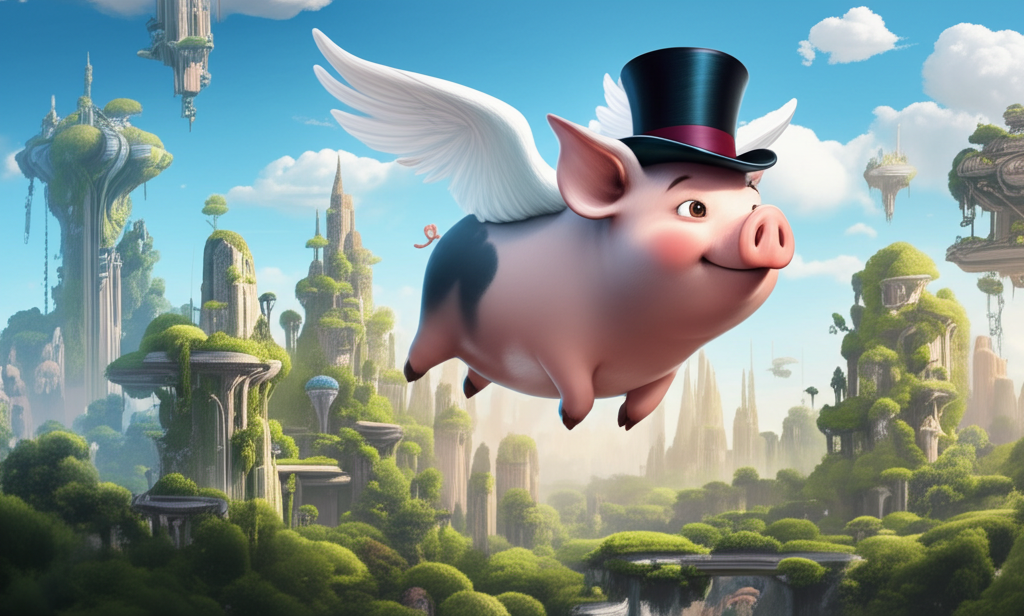

In [21]:
prompt = """Can you create a 3d rendered image of a pig with wings
and a top hat flying over a happy futuristic scifi city with lots
of greenery?
"""

response = client.models.generate_content(
    # Use the dedicated image generation model.
    model="gemini-2.0-flash-exp-image-generation",
    contents=prompt,
    # This model requires both text and image outputs.
    config=types.GenerateContentConfig(
      response_modalities=['text', 'image']
    )
)

for part in response.candidates[0].content.parts:

  if part.text:
    print(part.text)

  elif part.inline_data:
    display(Image(part.inline_data.data))

Image generation works in a chat conversation too, so you can ask the model follow-up questions and it can make edits to the image. You can also provide images as input, for the model to start from.

You can try writing this code yourself, but the easiest way to explore the feature is through [the image generation model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-exp-image-generation).

## Context caching

Context caching is a technique that allows you to cache part of a request, such that it does not need to be re-processed by the model each time you use it. This is useful, for example, for asking new questions of the same documents.

Note that context caching typically charges per million tokens per hour of caching. If you are using a paid API key, be sure to set your cache expiry or delete the cached tokens after use. See the [billing page](https://ai.google.dev/pricing) for more info. The Flash 1.5 model also supports caching on the free tier.

To ensure that the cache remains valid, caches are created by specifying versioned model names, so `gemini-1.5-flash-001`, where `-001` signifies the model version.

In [22]:
# Download the transcript
!wget -nv -O apollo11.txt https://storage.googleapis.com/generativeai-downloads/data/a11.txt

# Upload to the File API
transcript_file = client.files.upload(file='apollo11.txt')

# Create a cache
apollo_cache = client.caches.create(
    model='gemini-1.5-flash-001',
    config=types.CreateCachedContentConfig(
        system_instruction="You are a space history buff that enjoys discussing and explaining historical space events.",
        contents=[transcript_file],
    ),
)

apollo_cache

2025-04-06 15:06:41 URL:https://storage.googleapis.com/generativeai-downloads/data/a11.txt [847790/847790] -> "apollo11.txt" [1]


CachedContent(name='cachedContents/2l9nu42fz8n4', display_name='', model='models/gemini-1.5-flash-001', create_time=datetime.datetime(2025, 4, 6, 15, 6, 46, 850909, tzinfo=TzInfo(UTC)), update_time=datetime.datetime(2025, 4, 6, 15, 6, 46, 850909, tzinfo=TzInfo(UTC)), expire_time=datetime.datetime(2025, 4, 6, 16, 6, 44, 251690, tzinfo=TzInfo(UTC)), usage_metadata=CachedContentUsageMetadata(audio_duration_seconds=None, image_count=None, text_count=None, total_token_count=323391, video_duration_seconds=None))

Now you can use this cache when generating content.

In [23]:
response = client.models.generate_content(
    model=apollo_cache.model,
    config=types.GenerateContentConfig(
        cached_content=apollo_cache.name,
    ),
    contents="Find a nice moment from this transcript"
)

Markdown(response.text)

There are a couple of nice moments in the transcript, but one that stands out is on **Tape 4/5, Page 29**, when Buzz Aldrin, the Lunar Module pilot, observes the S-IVB booster:

"00 05 13 26 LMP
Houston, Apollo 11. We've got the - what appears to be the S IVB in sight - at - oh, I'd estimate a couple of miles away. It's at our number 5 window and the dump appears to be coming out of two radially opposite directions from the S IVB."

This is a nice moment because it shows Aldrin's excitement and wonder at seeing the booster and its venting process. It also highlights the sheer scale of the mission, as they are observing a massive piece of machinery from a distance of several miles.


The response object includes information about the number of tokens that were cached and otherwise used in the prompt.

In [24]:
response.usage_metadata.to_json_dict()

{'cache_tokens_details': [{'modality': 'TEXT', 'token_count': 323391}],
 'cached_content_token_count': 323391,
 'candidates_token_count': 182,
 'prompt_token_count': 323399,
 'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 323399}],
 'total_token_count': 323581}

And you can calculate how many non-cached tokens were used as input.

In [25]:
response.usage_metadata.total_token_count - response.usage_metadata.cached_content_token_count

190

### Delete the cache

To ensure you are not charged for any cached tokens you are not using, delete the cache. If you are on the free tier, you won't be charged, but it's good practice to clean up when you're done.

In [26]:
print(apollo_cache.name)
client.caches.delete(name=apollo_cache.name)

cachedContents/2l9nu42fz8n4


DeleteCachedContentResponse()

## Further reading

Take a look through the [Gemini API cookbook](https://github.com/google-gemini/cookbook) for more feature-based quickstarts and complex examples. And don't forget to explore [AI Studio](https://aistudio.google.com) to try out API features directly in the browser.

If you enabled billing on your API key and are finished with the key, you can [turn it off](https://ai.google.dev/gemini-api/docs/billing) unless you plan on using it again.

And **thank you** for coming with us on this 5-day learning journey!

\- [Mark McD](https://linktr.ee/markmcd)